All the libraries required throughtout the notebook are imported below

In [1]:
# Importing libraries
import numpy as np #Mathematical operation 
import matplotlib.pyplot as plt #Plotting library
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tqdm.notebook import tqdm,trange
import time

# Polynomial curve with normal noise.

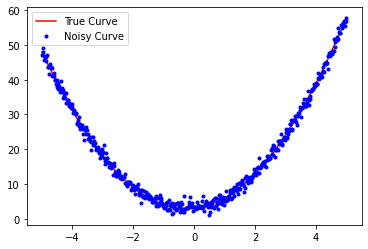

In [2]:
# Define the true polynomial coefficients
a = 2
b = 1
c = 3

# Define the range of x values
x = np.linspace(-5, 5, 501)

# Generate random normal noise with mean 0 and standard deviation 1
noise = np.random.normal(0, 1, len(x))

# Calculate the y values with added noise
y = a*x**2 + b*x + c + noise

# Plot the true curve and the noisy curve
plt.plot(x, a*x**2 + b*x + c, 'r-', label='True Curve')
plt.plot(x, y, 'b.', label='Noisy Curve')
plt.legend()
plt.show()


# GaussianP

A random 3rd order polynomial is provided as ground truth and the GaussianP algorithm is carried out using sklearn package. Radial basis function kernel (aka squared-exponential kernel) is used from sklearn library and a zero mean GaussianP prior is selected.

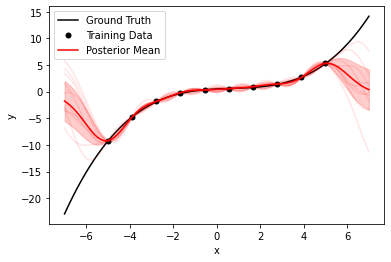

In [37]:
# Set seed for reproducibility
np.random.seed(42)

# Define ground truth polynomial curve
def ground_truth(x):
    return 0.5 + 0.2*x - 0.1*x**2 + 0.05*x**3

# Generate training data
n = 10 # number of training points
x_train = np.linspace(-5, 5, n)
y_train = ground_truth(x_train) + np.random.normal(scale=0.1, size=n)

# Define test points
x_test = np.linspace(-7, 7, 100)

# Define Gaussian process kernel
kernel = RBF(length_scale=1.0)

# Define Gaussian process prior
gp_prior = GaussianProcessRegressor(kernel=kernel, alpha=0,normalize_y=True)

# Fit Gaussian process to training data
gp_posterior = gp_prior.fit(x_train.reshape(-1,1), y_train)

# Predict mean and standard deviation of test points
y_mean, y_std = gp_posterior.predict(x_test.reshape(-1,1), return_std=True)

# Plot results
plt.figure()
plt.plot(x_test, ground_truth(x_test), 'k-', label='Ground Truth')
plt.plot(x_train, y_train, 'k.', markersize=10, label='Training Data')
plt.plot(x_test, y_mean, 'r-', label='Posterior Mean')
plt.fill_between(x_test, y_mean - y_std, y_mean + y_std, alpha=0.2, color='r')
y_samples = gp_posterior.sample_y(x_test.reshape(-1,1), 10) # To fill the color between the mean and the cov value
plt.plot(x_test, y_samples, 'r-', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Similar task like above is performed but this time without using any external libraries like sklearn or gflow. This process totally fails at predicting the correct function. I tried more conventional functions like sin(x), and it performs well in those cases. But I tried with 2nd and 3rd order polynomials it fails completely.

![](sin.png)

<p style="text-align: center;font-weight: bold"> Sin x fitting </p>

![](pol2.png)

<p style="text-align: center;font-weight: bold"> Polynomial order 2 (0.5 + 0.2*x - 0.1*x**2) fitting </p>

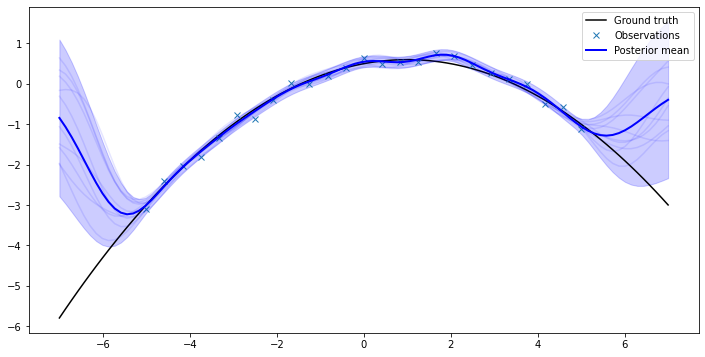

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ground truth polynomial curve
def true_curve(x):
    return 0.5 + 0.2*x - 0.1*x**2 + 0.05*x**3

# Generate noisy observations of the curve
np.random.seed(123)
x_obs = np.linspace(-5, 5, 25)
y_obs = true_curve(x_obs) + np.random.normal(loc=0, scale=0.1, size=len(x_obs))

# Define the kernel function
def squared_exponential_kernel(x1, x2, l=1.0, sigma=1.0):
    dist_sq = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2*np.dot(x1, x2.T)
    return sigma**2 * np.exp(-0.5 / l**2 * dist_sq)

# Define the Gaussian process model
def gp_regression(x_train, y_train, x_test, kernel, sigma_n=0.1):
    K = kernel(x_train, x_train)
    K_star = kernel(x_train, x_test)
    K_star_star = kernel(x_test, x_test)
    K_inv = np.linalg.inv(K + sigma_n**2 * np.eye(len(x_train)))
    mu = np.dot(K_star.T, np.dot(K_inv, y_train))
    cov = K_star_star - np.dot(K_star.T, np.dot(K_inv, K_star))
    return mu, cov

# Define test points
x_test = np.linspace(-7, 7, 100)[:, None]

# Compute posterior mean and variance
mu, cov = gp_regression(x_obs[:, None], y_obs, x_test, squared_exponential_kernel, sigma_n=0.1)

# Sample from the posterior
samples = np.random.multivariate_normal(mu.ravel(), cov, size=10)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x_test, true_curve(x_test), 'k', label='Ground truth')
plt.plot(x_obs, y_obs, 'x', label='Observations')
plt.plot(x_test, mu, 'b', lw=2, label='Posterior mean')
plt.fill_between(x_test[:, 0], mu - 2*np.sqrt(np.diag(cov)),
                 mu + 2*np.sqrt(np.diag(cov)), color='b', alpha=0.2)
for i in range(samples.shape[0]):
    plt.plot(x_test, samples[i], 'b', alpha=0.1)
plt.legend()
plt.savefig("pol2.png",dpi=100)
plt.show()

# Gaussian Mixture

1000 Datapoints are generated using Ancestral Sampling Scheming. First five generated data are printed out.

In [4]:
# Set the parameters
M = 3
alpha = np.ones(M) / M
means = np.array([[-1, 0], [1, 0], [0, 1]])
variance = 0.25**2
num_data_points = 1000

# Sample mixture weights from a Dirichlet distribution
mixing_weights = np.random.dirichlet(alpha)

# Sample component labels and data points for each data point
component_labels = np.zeros(num_data_points, dtype=int) #To store the choices of the draw
data_points = np.zeros((num_data_points, 2)) # To store the datapoints
for n in range(num_data_points):
    # Sample a component label from a categorical distribution
    component_labels[n] = np.random.choice(M, p=mixing_weights)
    
    # Sample a data point from a Gaussian distribution with the mean of the selected component
    data_points[n] = np.random.normal(loc=means[component_labels[n]], scale=np.sqrt(variance))

# Print the first few data points
print(data_points[:5])

[[-0.10701152  0.81439829]
 [ 0.36641219  0.94355592]
 [ 1.63987201  0.09855826]
 [-1.28774839  0.0939245 ]
 [ 0.84993654  0.23685996]]


Gibbs sampler to draw posterior samples

In [5]:
# Set the parameters
M = 3
alpha = np.ones(M) / M
means = np.array([[-1, 0], [1, 0], [0, 1]])
variance = 0.252
num_data_points = 1000

# Generate synthetic data
mixing_weights_true = np.random.dirichlet(alpha)
component_labels_true = np.zeros(num_data_points, dtype=int)
data_points = np.zeros((num_data_points, 2))
for n in range(num_data_points):
    component_labels_true[n] = np.random.choice(M, p=mixing_weights_true)
    data_points[n] = np.random.normal(loc=means[component_labels_true[n]], scale=np.sqrt(variance))

# Initialize the values of s1:N and πσ1:M
component_labels = np.zeros(num_data_points, dtype=int)
mixing_weights = np.ones(M) / M

# Set the number of iterations
num_iterations = 1000

# Run the Gibbs sampler
for t in trange(num_iterations):
    # Sample the values of s1:N from the conditional distribution p(s1:N | w1:N, πσ1:M)
    for n in range(num_data_points):
        posterior_probs = np.zeros(M) #To store the intermediate prosterior values
        for k in range(M):
            posterior_probs[k] = np.exp(-np.sum((data_points[n] - means[k]) ** 2) / (2 * variance)) * mixing_weights[k]
        posterior_probs /= np.sum(posterior_probs)
        component_labels[n] = np.random.choice(M, p=posterior_probs)

    # Sample the value of πσ1:M from the conditional distribution p(πσ1:M | s1:N, w1:N)
    mixing_weights = np.random.dirichlet(alpha + np.bincount(component_labels, minlength=M))

# Print the true and inferred mixture weights
print("True mixing weights:", mixing_weights_true)
print("Inferred mixing weights:", mixing_weights)
print("Error in inferred weights :",np.abs(mixing_weights_true-mixing_weights)*100/mixing_weights_true,"%")

  0%|          | 0/1000 [00:00<?, ?it/s]

True mixing weights: [0.12442482 0.85240826 0.02316692]
Inferred mixing weights: [0.12509537 0.84819123 0.0267134 ]
Error in inferred weights : [ 0.53891627  0.49471908 15.30838517] %


πσ1:2 are potted below along with the ground truth as the horizontal line.

  0%|          | 0/1000 [00:00<?, ?it/s]

True mixing weights: [0.01229262 0.02471209 0.96299529]
Inferred mixing weights: [2.92735386e-05 4.10406636e-04 9.99560320e-01]
Error in inferred weights : [99.76186084 98.33924751  3.79701002] %


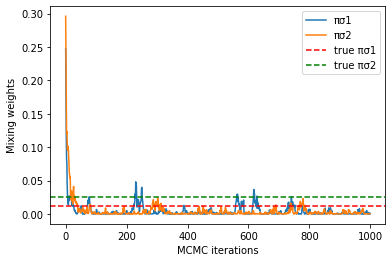

In [6]:
# Set the parameters
M = 3
alpha = np.ones(M) / M
means = np.array([[-1, 0], [1, 0], [0, 1]])
variance = 1
num_data_points = 1000

# Generate synthetic data
mixing_weights_true = np.random.dirichlet(alpha)
component_labels_true = np.zeros(num_data_points, dtype=int)
data_points = np.zeros((num_data_points, 2))
for n in range(num_data_points):
    component_labels_true[n] = np.random.choice(M, p=mixing_weights_true)
    data_points[n] = np.random.normal(loc=means[component_labels_true[n]], scale=np.sqrt(variance))

# Initialize the values of s1:N and πσ1:M
component_labels = np.zeros(num_data_points, dtype=int)
mixing_weights = np.ones(M) / M

# Set the number of iterations
num_iterations = 1000

# Create arrays to store the mixing weights
mixing_weights_history = np.zeros((num_iterations, 2))

# Run the Gibbs sampler
for t in trange(num_iterations):
    # Sample the values of s1:N from the conditional distribution p(s1:N | w1:N, πσ1:M)
    for n in range(num_data_points):
        posterior_probs = np.zeros(M)
        for k in range(M):
            posterior_probs[k] = np.exp(-np.sum((data_points[n] - means[k]) ** 2) / (2 * variance)) * mixing_weights[k]
        posterior_probs /= np.sum(posterior_probs)
        component_labels[n] = np.random.choice(M, p=posterior_probs)

    # Sample the value of πσ1:M from the conditional distribution p(πσ1:M | s1:N, w1:N)
    mixing_weights = np.random.dirichlet(alpha + np.bincount(component_labels, minlength=M))

    # Store the mixing weights
    mixing_weights_history[t] = mixing_weights[:2]

# Print the true and inferred mixture weights
print("True mixing weights:", mixing_weights_true)
print("Inferred mixing weights:", mixing_weights)
print("Error in inferred weights :",np.abs(mixing_weights_true-mixing_weights)*100/mixing_weights_true,"%")

# Plot the mixing weights as a function of iterations
plt.plot(mixing_weights_history[:, 0], label="πσ1") #Plotting the first weight
plt.plot(mixing_weights_history[:, 1], label="πσ2") #Plotting the 2nd weight
plt.axhline(y=mixing_weights_true[:2][0], color='r', linestyle='--', label="true πσ1") #Ground truth weight 1
plt.axhline(y=mixing_weights_true[:2][1], color='g', linestyle='--', label="true πσ2") # Ground truth weight 2
# plt.ylim(mixing_weights_true[:2][1]-0.01, mixing_weights_true[:2][0]+0.01) #Setting the limit of the y axis
plt.legend() #Show the legends
plt.xlabel("MCMC iterations") #xlabels
plt.ylabel("Mixing weights") #ylabels
# plt.savefig("1.png",dpi=100)
plt.show()

Weights and the plot of the πσ1:2 is shown below. The error in estimation of the weights follows more or less the same pattern irrespective of the change in the variations.

|Variance| w1 true  | w1 estimated | w2 true  | w2 estimated | w3 true  | w3 estimated |%Err w1|%Err w2|%Err w3|
|--------|----------|--------------|----------|--------------|----------|--------------|-------|-------|-------|
|0.25^2  |0.3897|0.4086|0.0449|0.0257|0.5652|0.5655|4.85%|42.66% |0.05%  |
|0.5^2   |0.9010|0.8826|0.0104|0.0150|0.0884|0.1023|2.05%|44.75% |15.62  |
|1       |0.7082|0.6610|0.0250|0.0264|0.2667|0.3124|6.66%|5.82%  |17.14  |


![](25.png)

<p style="text-align: center;font-weight: bold"> Variance = 0.25^2 </p>

![](5.png)

<p style="text-align: center;font-weight: bold"> Variance = 0.5^2</p>

![](1.png)

<p style="text-align: center;font-weight: bold"> Variance = 1 </p>